In [410]:
# Load libraries and functions
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [411]:
# Turn off warnings to reduce angry red-space in notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Identify city and date range of interest (same as used within Twitter scrape)

In [412]:
city = 'Houston'
start_date = dt.date(2014, 1, 1)
end_date = dt.date(2018, 1, 1)

In [413]:
# Read .csv created with above parameters
df = pd.read_csv(f'../data/tweetscrape_{city}_{start_date}_to_{end_date}.csv')

In [414]:
# Create df with only columns of interest
tweets = df[['username', 'tweet_id', 'timestamp', 'timestamp_epochs', 'retweets', 'text']]

In [415]:
tweets.shape

(33036, 6)

In [416]:
tweets['timestamp'].dtypes

dtype('O')

### Manipulate timestamp

#### Remove seconds and convert to date-time

In [417]:
# loop through rows to change timestamp format into something functional:

date_list = []

for tweet in tweets['timestamp']:
    tweet = tweet.replace(' ', '')[:-8]
    date_list.append(tweet)
    
tweets['clean_date'] = date_list
tweets['clean_date']

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0        2014-05-26
1        2014-05-26
2        2014-05-26
3        2014-05-26
4        2014-05-26
            ...    
33031    2017-08-08
33032    2017-08-08
33033    2017-08-08
33034    2017-08-08
33035    2017-08-08
Name: clean_date, Length: 33036, dtype: object

In [418]:
tweets

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
0,mark_tarello,471077480262930432,2014-05-26 23:56:38,1401148598,1,FLOODING from heavy rain this afternoon near H...,2014-05-26
1,Djtexasoutlaw,471074963911213056,2014-05-26 23:46:38,1401147998,0,Flood on di main road! #Houston #Flood http://...,2014-05-26
2,laurenalexxis,471067687708143616,2014-05-26 23:17:43,1401146263,0,Stay safe! #rain #flood #storm #houston #sugar...,2014-05-26
3,leenstaraileen,471067572490616832,2014-05-26 23:17:15,1401146235,0,My daughters boat is floating... #houston #flo...,2014-05-26
4,ImJohnsirz,471066240975654912,2014-05-26 23:11:58,1401145918,0,Welp we lost power her at walgreens. Gonna hav...,2014-05-26
...,...,...,...,...,...,...,...
33031,CivilDefWatch,894847747551088640,2017-08-08 09:08:23,1502183303,0,"weatherchannel: 4-7"" of rain -> widespread fla...",2017-08-08
33032,weatherchannel,894845828010999808,2017-08-08 09:00:45,1502182845,27,"4-7"" of rain -> widespread flash #flooding in ...",2017-08-08
33033,wxjerdman,894839680721711105,2017-08-08 08:36:19,1502181379,1,"Mon AM: San Antonio. This AM: #Houston. 2-3""/h...",2017-08-08
33034,kimconde752,894810035922104320,2017-08-08 06:38:31,1502174311,1,"Well, not what I wanted to come home to \n#H...",2017-08-08


In [419]:
tweets['clean_date'] = pd.to_datetime(tweets['clean_date'], format='%Y-%m-%d')

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [420]:
tweets.dtypes

username                    object
tweet_id                     int64
timestamp                   object
timestamp_epochs             int64
retweets                     int64
text                        object
clean_date          datetime64[ns]
dtype: object

#### Convert original timestamp to datetime

In [421]:
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [422]:
# Identify # of unique cells in this column
tweets['timestamp'].nunique()

30940

In [423]:
df.shape[0]

33036

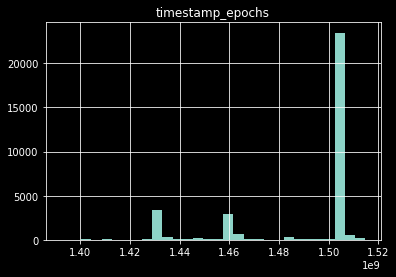

In [424]:
tweets.hist(column = 'timestamp_epochs', bins = 30);

In [425]:
tweets.describe()

,tweet_id,timestamp_epochs,retweets
count,3.303600e+04,3.303600e+04,33036.000000
mean,8.416015e+17,1.489488e+09,4.245308
std,1.110064e+17,2.646600e+07,79.193981
min,4.338489e+17,1.392273e+09,0.000000
25%,7.861027e+17,1.476256e+09,0.000000
50%,9.023256e+17,1.503966e+09,0.000000
75%,9.032062e+17,1.504176e+09,0.000000
max,9.475989e+17,1.514760e+09,7466.000000


In [426]:
tweets[tweets['retweets'] > 500]

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
8301,weatherchannel,603165438302932992,2015-05-26 11:47:01,1432640821,537,How bad is the #flooding in #Houston? This pic...,2015-05-26
11044,nytimes,907417747239436288,2017-09-12 01:37:04,1505180224,739,Floodwaters in 2 Houston neighborhoods have be...,2017-09-12
13249,AP,904032948994928640,2017-09-02 17:27:05,1504373225,2173,AP Exclusive: Floodwaters inundate at least 5 ...,2017-09-02
15241,ABC,903444880583782403,2017-09-01 02:30:19,1504233019,1978,Monster truck helps rescue a U.S. Army truck s...,2017-09-01
15456,abc13houston,903399989203886080,2017-08-31 23:31:56,1504222316,529,#TEXASSTRONG: Monster truck owners from Dallas...,2017-08-31
15720,ABC,903357606793809921,2017-08-31 20:43:31,1504212211,945,Monster truck helps rescue a U.S. Army truck s...,2017-08-31
18975,RedTRaccoon,902936573594877952,2017-08-30 16:50:29,1504111829,1117,"Update for #flood vicitims in Houston, Port Ar...",2017-08-30
19318,RedTRaccoon,902909197884514308,2017-08-30 15:01:42,1504105302,1386,"Resources for #flood vicitims in Houston, Port...",2017-08-30
19538,kylegriffin1,902883204859875332,2017-08-30 13:18:25,1504099105,1766,Trump still hasn't mentioned Houston Police Sg...,2017-08-30
19698,CollinsUma,902854954439905280,2017-08-30 11:26:10,1504092370,7466,"While you're standing with Houston, please als...",2017-08-30


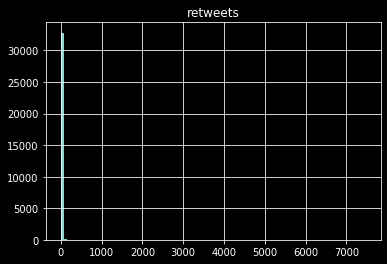

In [427]:
tweets.hist(column = 'retweets', bins = 100);

In [428]:
# Identify duplicate tweet content (identical shared newsitems, users with multiple twitter accounts, etc)
tweets[tweets.duplicated(['text'])]

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
20,mark_tarello,471077480262930432,2014-05-26 23:56:38,1401148598,1,FLOODING from heavy rain this afternoon near H...,2014-05-26
21,Djtexasoutlaw,471074963911213056,2014-05-26 23:46:38,1401147998,0,Flood on di main road! #Houston #Flood http://...,2014-05-26
22,laurenalexxis,471067687708143616,2014-05-26 23:17:43,1401146263,0,Stay safe! #rain #flood #storm #houston #sugar...,2014-05-26
23,leenstaraileen,471067572490616832,2014-05-26 23:17:15,1401146235,0,My daughters boat is floating... #houston #flo...,2014-05-26
24,ImJohnsirz,471066240975654912,2014-05-26 23:11:58,1401145918,0,Welp we lost power her at walgreens. Gonna hav...,2014-05-26
...,...,...,...,...,...,...,...
32868,Texas_Sugar,901313561640787968,2017-08-26 05:21:13,1503724873,0,#Houston Family's system to protect home from ...,2017-08-26
32869,TheSafetyMaster,901313526085677056,2017-08-26 05:21:04,1503724864,0,#Houston Family's system to protect home from ...,2017-08-26
32871,JGiannangelo,901313454140796928,2017-08-26 05:20:47,1503724847,0,#Houston Family's system to protect home from ...,2017-08-26
32872,JadieGirl77479,901313416035545088,2017-08-26 05:20:38,1503724838,0,#Houston Family's system to protect home from ...,2017-08-26


In [429]:
tweets = tweets.drop_duplicates(['text'])

In [430]:
tweets.shape

(28139, 7)

In [431]:
tweet_count_month = tweets.groupby([tweets["clean_date"].dt.year, tweets["clean_date"].dt.month])[['text']].count()

In [432]:
# Thus our clean_date becomes the index for our data...
daily_tweets = tweets.groupby(tweets['clean_date'])[['text']].count()

In [433]:
tweet_count_month

text
clean_date clean_date       
2014       2               2
           3               2
           4               1
           5              88
           6              13
           7               7
           8              26
           9              75
           10             10
           11              1
           12              6
2015       1              10
           2               2
           3              20
           4              70
           5            2973
           6             252
           7              52
           8              43
           9              36
           10            208
           11             51
           12             35
2016       1              18
           2              20
           3              56
           4            2592
           5             310
           6             296
           7              44
           8              36
           9              21
           10              5
           11              1
           12             20
2017       1             254
           2              31
           3              46
           4              37
           5              15
           6              63
           7              10
           8           15057
           9            4698
           10            313
           11             99
           12            114

In [434]:
tweets['year'] = tweets['clean_date'].dt.year
tweets['month'] = tweets['clean_date'].dt.month

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [435]:
test = tweets.groupby([tweets["year"], tweets["month"]])[['text']].count()

In [436]:
test.reset_index()

,year,month,text
0,2014,2,2
1,2014,3,2
2,2014,4,1
3,2014,5,88
4,2014,6,13
5,2014,7,7
6,2014,8,26
7,2014,9,75
8,2014,10,10
9,2014,11,1


In [437]:
tweet_count_month[:][1:3]

text
clean_date clean_date      
2014       3              2
           4              1

### Set Timestamp to Index for TimeSeries

In [438]:
tweets.index.type

AttributeError: 'Int64Index' object has no attribute 'type'

In [ ]:
tweets.set_index('timestamp', inplace = True)
tweets.sort_index(inplace = True)

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

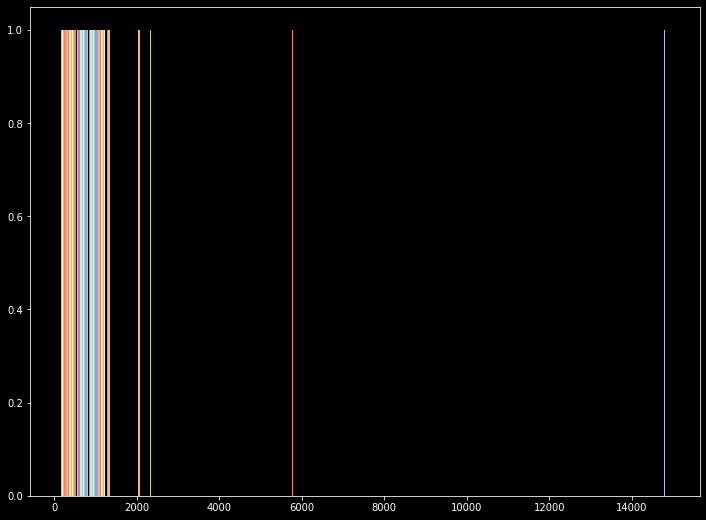

In [440]:
fig, ax = plt.subplots(figsize = (12, 9))

ax.hist(tweet_count_month)

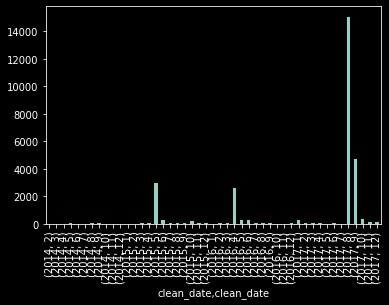

In [441]:
tweets['text'].groupby([tweets["clean_date"].dt.year, tweets["clean_date"].dt.month]).count().plot(kind="bar");

In [442]:
daily_tweets.resample('W').count()

,text
clean_date,
2014-02-16,1
2014-02-23,1
2014-03-02,0
2014-03-09,0
2014-03-16,0
...,...
2017-12-03,7
2017-12-10,7
2017-12-17,7


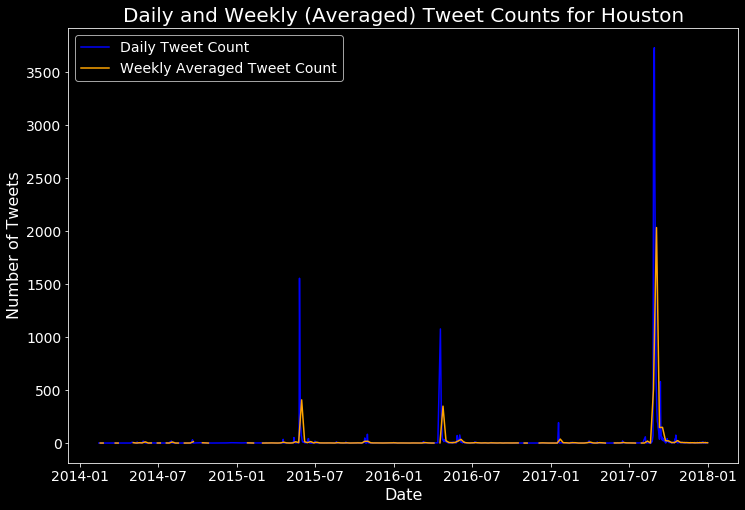

In [447]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Weekly Averaged Tweet Count'], fontsize = 14);
ax.set_title(f'Daily and Weekly (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/dailyct_and_weeklyavg_tweets_{city}.png')

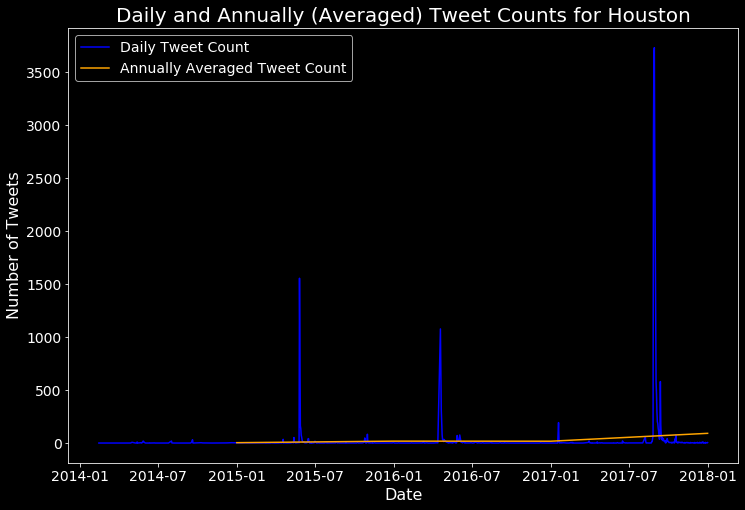

In [449]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('A').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Annually Averaged Tweet Count'], fontsize = 14);
ax.set_title(f'Daily and Annually (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/dailyct_and_annavg_tweets_{city}.png')

In [450]:
daily_tweets

,text
clean_date,
2014-02-13,1
2014-02-22,1
2014-03-18,1
2014-03-28,1
2014-04-28,1
...,...
2017-12-27,2
2017-12-28,4
2017-12-29,3


In [451]:
# Overall average can be skewed by an anomalous year
daily_tweets['text'].mean()

42.31428571428572

In [452]:
# Get annual averaged numbers of tweets instead
mean_ann_tweets = daily_tweets[['text']].resample('A').mean()

In [453]:
mean_ann_tweets.index = mean_ann_tweets.index.year

In [454]:
daily_tweets

,text
clean_date,
2014-02-13,1
2014-02-22,1
2014-03-18,1
2014-03-28,1
2014-04-28,1
...,...
2017-12-27,2
2017-12-28,4
2017-12-29,3


In [455]:
mean_ann_tweets

,text
clean_date,
2014,4.277778
2015,18.854271
2016,18.186170
2017,92.575893


In [456]:
# Identify all days with tweet counts greater than their respective annual average
bool_list = []
for i in range(len(daily_tweets)):
    bool_list.append(daily_tweets['text'][i] >= mean_ann_tweets.loc[daily_tweets.index[0].year,'text'])
daily_tweets['above_avg'] = bool_list

In [457]:
daily_tweets[daily_tweets['above_avg']==True]

,text,above_avg
clean_date,,
2014-05-01,8,True
2014-05-13,11,True
2014-05-26,12,True
2014-05-27,19,True
2014-05-28,18,True
...,...,...
2017-12-18,9,True
2017-12-19,10,True
2017-12-21,9,True


In [458]:
# Create new dataframe just for days with above average tweet counts
above_avg_tweets = daily_tweets.loc[daily_tweets['above_avg'] == True].drop(columns = 'above_avg')

In [459]:
(above_avg_tweets.resample('W').sum())['text']

clean_date
2014-05-04     8
2014-05-11     0
2014-05-18    11
2014-05-25     0
2014-06-01    58
              ..
2017-12-03     6
2017-12-10     7
2017-12-17    13
2017-12-24    28
2017-12-31    12
Freq: W-SUN, Name: text, Length: 192, dtype: int64

In [460]:
above_avg_tweets

,text
clean_date,
2014-05-01,8
2014-05-13,11
2014-05-26,12
2014-05-27,19
2014-05-28,18
...,...
2017-12-18,9
2017-12-19,10
2017-12-21,9


In [461]:

daily_tweets[daily_tweets['text'] > daily_tweets['text'].mean()]

,text,above_avg
clean_date,,
2015-05-13,53,True
2015-05-26,1556,True
2015-05-27,866,True
2015-05-28,164,True
2015-05-29,137,True
2015-05-30,75,True
2015-05-31,57,True
2015-06-16,43,True
2015-10-25,49,True


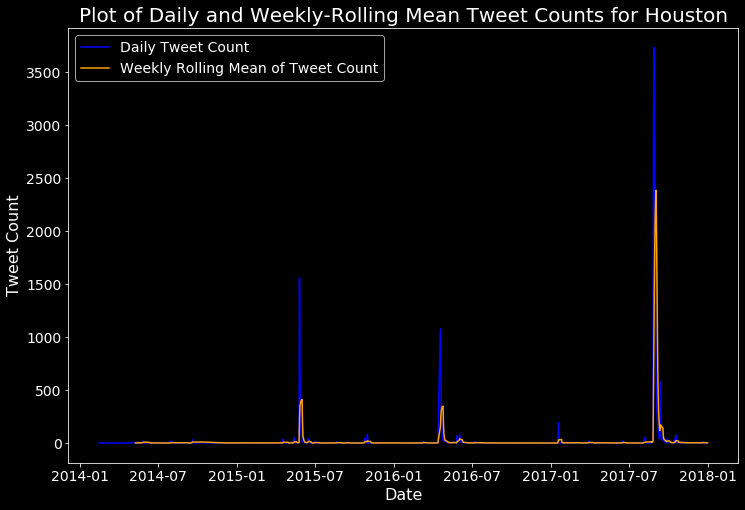

In [462]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], label = 'Daily Tweet Count', color = 'blue');
ax.plot(daily_tweets['text'].rolling(7).mean(), label = 'Weekly Rolling Mean of Tweet Count', color = 'orange');
ax.set_title(f'Plot of Daily and Weekly-Rolling Mean Tweet Counts for {city}', fontsize = 20);
ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Tweet Count', fontsize = 16);
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize = 14)
plt.savefig(f'../figs/daily_weeklyrollingmean_{city}.png')


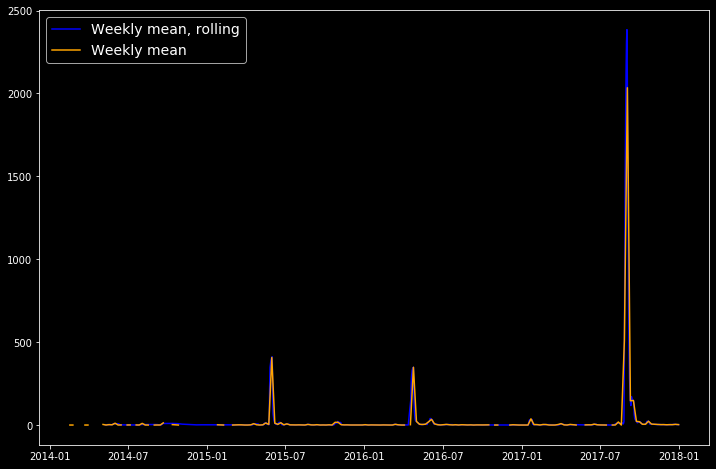

In [463]:
plt.figure(figsize = (12, 8))
plt.plot(daily_tweets['text'].rolling(7).mean(), color = 'blue');
plt.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
plt.legend(['Weekly mean, rolling', 'Weekly mean'], fontsize = 14);

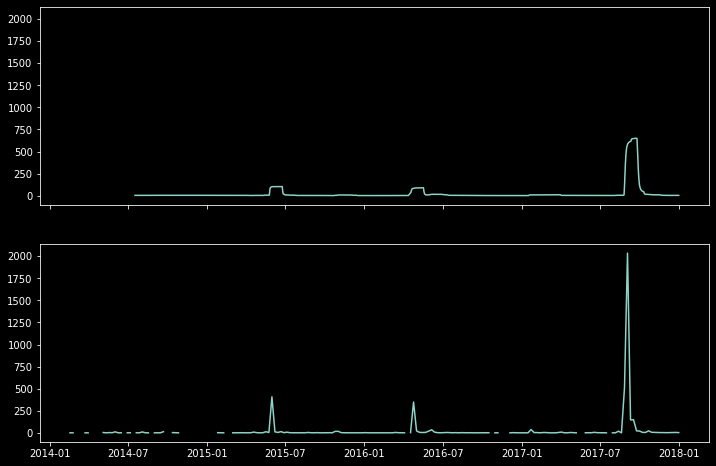

In [464]:
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8), sharex = True, sharey = True)

ax[0].plot(daily_tweets['text'].rolling(30).mean());
ax[1].plot(daily_tweets['text'].resample('W').mean());

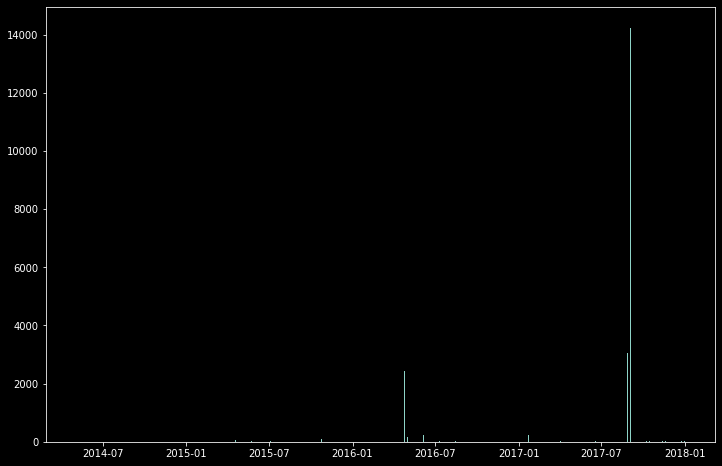

In [465]:
plt.figure(figsize = (12, 8))
plt.bar(above_avg_tweets['text'].resample('W').sum().index, above_avg_tweets['text'].resample('W').sum());

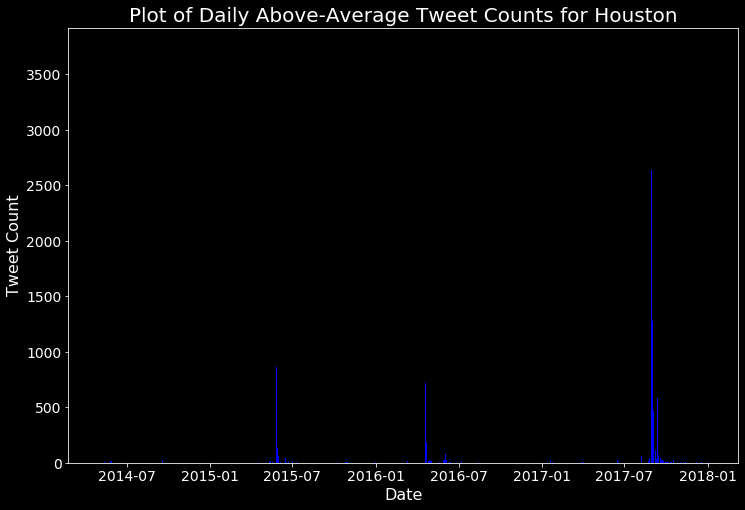

In [466]:
plt.figure(figsize = (12, 8))
plt.bar(above_avg_tweets['text'].index, above_avg_tweets['text'], color = 'blue');
plt.title(f'Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Tweet Count', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/daily_abvavg_{city}.png')

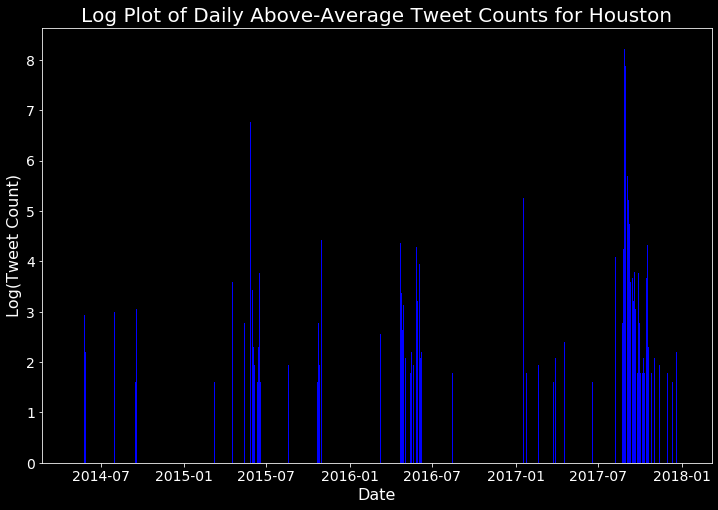

In [467]:
plt.figure(figsize = (12, 8));
plt.bar(above_avg_tweets['text'].index, np.log(above_avg_tweets['text']), color = 'blue');
plt.title(f'Log Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Log(Tweet Count)', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/log_daily_abvavg_{city}.png')

### CountVectorizer & Show Most Frequent Words

In [ ]:
cvec_tw = CountVectorizer()

In [ ]:
stopWords = ['com', 'http', 'twitter', 'https', 'pic', 'www', 'ly', 
             'yahoo', 'yhoo', 'youtu', 'youtube', 'fb', 'instagram', 
             'tt', 'html'] + list(ENGLISH_STOP_WORDS) 

In [ ]:
# Initiate instance of CountVectorizer for tweet data
cvec_tw = CountVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

# Pull out 'title' column from climatechange data
X_tw = tweets['text']

# Fit the vectorizer to our corpus
cvec_tw.fit(X_tw)

# Transform the training corpus
X_tw = cvec_tw.transform(X_tw)

# Convert result into a dataframe
X_tw_df = pd.DataFrame(X_tw.toarray(),
                          columns=cvec_tw.get_feature_names())
X_tw_df.head()

In [ ]:
X_tw_df.shape

In [ ]:
# Save 20 most frequently appearing words to a df, in descending order
tw_bardat = X_tw_df.sum().sort_values(ascending = False)[0:20].to_frame()

In [ ]:
tw_bardat.index

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9), sharex = True, constrained_layout = True, # Share x axes to keep ranges the same
                              facecolor = '#E0E0E0')  # Set figure facecolor to match slide theme
ax.barh(tw_bardat.index, tw_bardat[0]);
ax.invert_yaxis(); # Flip plot vertically so values descending from top
ax.set_title(f'Word Frequency Across {city}-related Tweets', fontsize = 20);
ax.set_xlabel('Word Frequency', fontsize = 16);
ax.set_yticklabels(tw_bardat.index, fontsize = 14)
ax.tick_params(labelsize = 16)
         

In [ ]:
# For loop to do most of my 'Title' cleaning--remove punctuation, convert to lowercase, lemmatize
# With guidance from Preeya Sawadmanod

text_puncless = []
text_lemmed = []

for row in tweets['text']:
    # Instantiate tokenizer/set to remove punctuation, numbers, and any 'words' comprised of just 1 character
    # Numbers removed because many were completely extraneous
    # And the ones that might have been useful weren't useful enough to justify keeping the rest
    tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') # (r'\w+')

    # Instantiate lemmatizer: lemmatizer over stemmer because false negatives are preferable here to false positives
    # We don't want to over-estimate the accuracy of our predictions
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize each row (also do the change to lower-case here)
    rows = tokenizer.tokenize(row.lower())
    
    # Lemmatize all words in each row
    lem_rows = [lemmatizer.lemmatize(word) for word in rows]
    
    # Change each row back from a list of strings to a single string
    rows = ' '.join(rows)
    lem_rows = ' '.join(lem_rows)
    
    # Append fixed rows to their respective lists
    text_puncless.append(rows)
    text_lemmed.append(lem_rows)

In [ ]:
len(text_puncless)

In [ ]:
tweets.shape

In [ ]:
# Insert cleaned lists of titles into dataframe as new columns
tweets['text_nopunc'] = text_puncless
tweets['text_lemmed'] = text_lemmed

In [ ]:
tweets.head()

In [ ]:
# WORD-TO-VEC ???? Try kmeans with and without word2vec
# Support vector machines
# KMeans
# Cosine similarity?


In [ ]:
X = tweets['text_lemmed']


### KMeans clustering with CountVectorizer

In [ ]:
cvec_X = CountVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

# Pull out 'title' column from climatechange data
X_cvec = X

# Fit the vectorizer to our corpus
cvec_X.fit(X_cvec)

# Transform the training corpus
X_cvec = cvec_X.transform(X_cvec)

# Convert result into a dataframe
X_cvec_df = pd.DataFrame(X_cvec.toarray(),
                          columns=cvec_X.get_feature_names())
X_cvec_df.head()

In [ ]:
Xcols = list(X_cvec_df.columns)

In [ ]:
km = KMeans(n_clusters = 5, random_state = 42)
sc = StandardScaler()
X_sc = sc.fit_transform(X_cvec_df[Xcols])

In [ ]:
km.fit(X_sc)

In [ ]:
km.cluster_centers_

In [ ]:
tweets["cluster"] = km.labels_
tweets.tail()

In [ ]:
tweets.groupby(['cluster']).count()

In [ ]:
plt.figure(figsize=(7,7));

## Plot scatter by cluster / color, and centroids
colors = ["red", "green", "blue"]
tweets['color'] = tweets['cluster'].map(lambda p: colors[p])

### Kmeans Clustering with TFIDF

In [ ]:
# Fit the transformer.
tvec_X = TfidfVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

In [ ]:
tvec_X

In [ ]:
# Pull out 'title' column from climatechange data
X_tvec = X

# Fit the vectorizer to our corpus
tvec_X.fit(X_tvec)

# Transform the training corpus
X_tvec = tvec_X.transform(X_tvec)

# Convert result into a dataframe
X_tvec_df = pd.DataFrame(X_tvec.toarray(),
                          columns=tvec_X.get_feature_names())
X_tvec_df.head()

In [ ]:
X_tvec[100:102,:]

In [ ]:
Xcols = list(X_tvec_df.columns)

In [ ]:
km = KMeans(n_clusters = 5, random_state = 86753)
sc = StandardScaler()
X_sc = sc.fit_transform(X_tvec_df[Xcols])

In [ ]:
km.fit(X_tvec)

In [ ]:
km.n_iter_

In [ ]:
km.cluster_centers_

In [ ]:
tweets["cluster"] = km.labels_
tweets.tail()

In [ ]:
tweets.groupby(['cluster']).count()

In [ ]:
silhouette_score(X_sc, km.labels_)

In [ ]:
km.inertia_

In [ ]:
# Now testing a varying k
scores = []
for k in range(2, 31):
    km = KMeans(k, random_state=1234)
    km.fit(X_tvec)
    inertia = km.inertia_
    sil = silhouette_score(X_tvec, km.labels_)
    scores.append((k, inertia, sil))

In [ ]:
score_df = pd.DataFrame(scores, columns=["k", "inertia", "sil"])
score_df.head()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7));
axes[0].plot(score_df.k, score_df.inertia);
axes[0].set_title('Inertia over k');
axes[1].plot(score_df.k, score_df.sil);
axes[1].set_title('Silhouette Score over k');

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('km', KMeans())
])

In [ ]:
pipe_params = {
    'cvec__max_features': [500],
    'cvec__min_df': [2],
    'cvec__max_df': [0.98],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': [stopWords],
    'km__n_clusters': [3, 5],
    'km__random_state': [42]
}

In [ ]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=3) # 3-fold cross-validation.

In [ ]:
gs.fit(X)

In [ ]:
gs.cluster_centers_